# Sparse Wide-ResNet

In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchvision.datasets import CIFAR10
from torchvision import transforms

from utils.train_utils import ModelTrainer, plot_history
from models.wide_resnet import SparseWideResNet
from utils.attacks import pgd

In [3]:
tr_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
vl_transform = transforms.Compose([
    transforms.ToTensor()
])

ds_train = CIFAR10('../data', train=True, download=True, transform=tr_transform)
ds_test = CIFAR10('../data', train=False, download=True, transform=vl_transform)

Files already downloaded and verified
Files already downloaded and verified


# Natural training

cuda
Epoch: 1 Validation Loss: 1.6405 accuracy: 0.4034, time: 0:07:27                
Epoch: 2 Validation Loss: 1.3789 accuracy: 0.5168, time: 0:08:30                
Epoch: 3 Validation Loss: 1.8353 accuracy: 0.4718, time: 0:08:29                
epochs_no_improve: 1/5
Epoch: 4 Validation Loss: 1.0538 accuracy: 0.6434, time: 0:07:19                
Epoch: 5 Validation Loss: 0.9025 accuracy: 0.6942, time: 0:08:28                
Epoch: 6 Validation Loss: 1.0859 accuracy: 0.6530, time: 0:08:29                
epochs_no_improve: 1/5
Epoch: 7 Validation Loss: 0.8687 accuracy: 0.7127, time: 0:08:28                
Epoch: 8 Validation Loss: 0.9403 accuracy: 0.6985, time: 0:04:51                
epochs_no_improve: 1/5
Epoch: 9 Validation Loss: 0.7587 accuracy: 0.7514, time: 0:03:43                
Epoch: 10 Validation Loss: 0.7860 accuracy: 0.7478, time: 0:06:09               
epochs_no_improve: 1/5
Epoch: 11 Validation Loss: 0.7921 accuracy: 0.7574, time: 0:08:24               
epochs_no_im

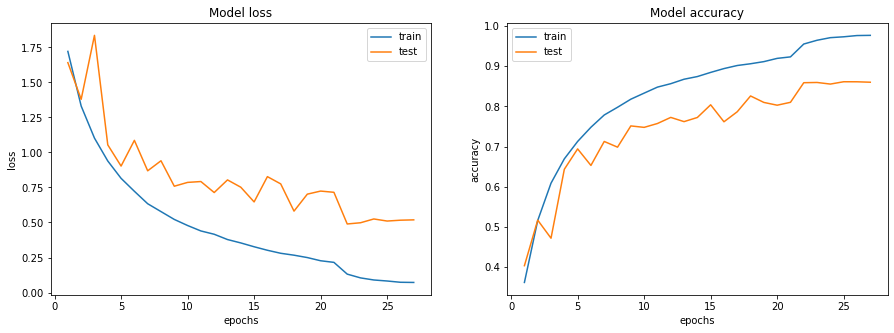

In [4]:
trainer = ModelTrainer(ds_train, ds_test, is_sparse=True, batch_size=100)

model = SparseWideResNet(depth=28, widen_factor=10, k_winners=0.1, local=False, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=50, patience=5)
plot_history(history)
torch.save(model.state_dict(), "../saved/sparse_wide_resnet.pt")

cuda
Epoch: 1 Validation Loss: 1.8705 accuracy: 0.3625, time: 0:06:15                
Epoch: 2 Validation Loss: 2.3805 accuracy: 0.3687, time: 0:08:24                
epochs_no_improve: 1/5
Epoch: 3 Validation Loss: 1.5656 accuracy: 0.5043, time: 0:08:24                
Epoch: 4 Validation Loss: 2.0054 accuracy: 0.4445, time: 0:08:23                
epochs_no_improve: 1/5
Epoch: 5 Validation Loss: 1.2098 accuracy: 0.6066, time: 0:08:17                
Epoch: 6 Validation Loss: 1.0734 accuracy: 0.6351, time: 0:08:22                
Epoch: 7 Validation Loss: 0.9984 accuracy: 0.6743, time: 0:08:21                
Epoch: 8 Validation Loss: 1.4858 accuracy: 0.5804, time: 0:08:17                
epochs_no_improve: 1/5
Epoch: 9 Validation Loss: 0.8896 accuracy: 0.7001, time: 0:08:23                
Epoch: 10 Validation Loss: 0.9573 accuracy: 0.6967, time: 0:08:22               
epochs_no_improve: 1/5
Epoch: 11 Validation Loss: 0.8884 accuracy: 0.7063, time: 0:08:22               
Epoch: 12 Va

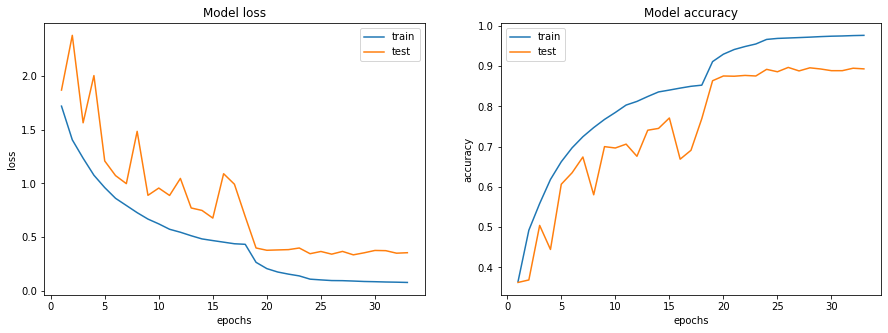

In [5]:
torch.cuda.empty_cache()
trainer = ModelTrainer(ds_train, ds_test, is_sparse=True, batch_size=100)

model = SparseWideResNet(depth=28, widen_factor=10, k_winners=0.1, local=False, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=50, patience=5)
plot_history(history)
torch.save(model.state_dict(), "../saved/sparse_wide_resnet_sgd_global.pt")

cuda
Epoch: 1 Validation Loss: 9.5921 accuracy: 0.2346, time: 0:04:31                
Epoch: 2 Validation Loss: 5.4413 accuracy: 0.3214, time: 0:05:56                
Epoch: 3 Validation Loss: 4.3032 accuracy: 0.3359, time: 0:06:39                
Epoch: 4 Validation Loss: 2.3422 accuracy: 0.4902, time: 0:06:39                
Epoch: 5 Validation Loss: 2.6621 accuracy: 0.4384, time: 0:06:39                
epochs_no_improve: 1/5
Epoch: 6 Validation Loss: 1.6113 accuracy: 0.5687, time: 0:06:07                
Epoch: 7 Validation Loss: 2.1358 accuracy: 0.5072, time: 0:06:18                
epochs_no_improve: 1/5
Epoch: 8 Validation Loss: 1.8766 accuracy: 0.5122, time: 0:06:27                
epochs_no_improve: 2/5
Epoch: 9 Validation Loss: 1.5094 accuracy: 0.5943, time: 0:06:36                
Epoch: 10 Validation Loss: 1.3796 accuracy: 0.5933, time: 0:06:35               
Epoch: 11 Validation Loss: 1.3215 accuracy: 0.6283, time: 0:06:36               
Epoch: 12 Validation Loss: 1.5259 a

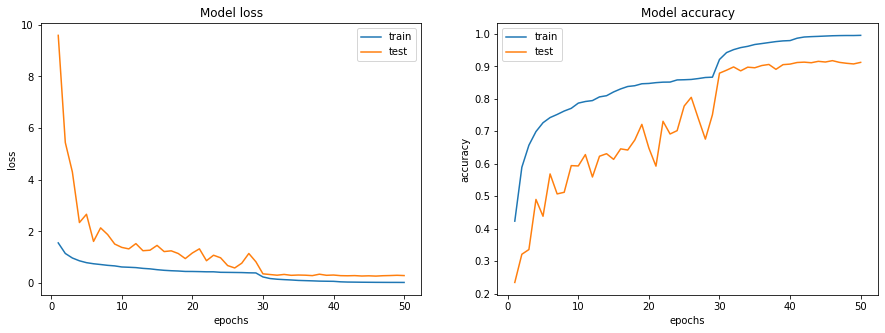

In [6]:
trainer = ModelTrainer(ds_train, ds_test, is_sparse=True, batch_size=100)

model = SparseWideResNet(depth=28, widen_factor=10, k_winners=0.1, local=True, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-5, patience=2, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=50, patience=5)
plot_history(history)
torch.save(model.state_dict(), "../saved/sparse_wide_resnet_sgd_local.pt")

### Turn off boosting

cuda
Epoch: 1 Validation Loss: 1.7303 accuracy: 0.3938, time: 0:03:43                
Epoch: 2 Validation Loss: 1.8982 accuracy: 0.3857, time: 0:03:42                
epochs_no_improve: 1/10
Epoch: 3 Validation Loss: 1.4528 accuracy: 0.5080, time: 0:03:42                
Epoch: 4 Validation Loss: 1.5873 accuracy: 0.5216, time: 0:03:42                
epochs_no_improve: 1/10
Epoch: 5 Validation Loss: 1.1026 accuracy: 0.6330, time: 0:03:41                
Epoch: 7 Validation Loss: 0.8888 accuracy: 0.7009, time: 0:03:42                
Epoch: 8 Validation Loss: 0.9542 accuracy: 0.6895, time: 0:03:43                
epochs_no_improve: 1/10
Epoch: 9 Validation Loss: 0.8409 accuracy: 0.7282, time: 0:03:42                
Epoch: 10 Validation Loss: 1.0430 accuracy: 0.6715, time: 0:03:42               
epochs_no_improve: 1/10
Epoch: 11 Validation Loss: 0.9707 accuracy: 0.6927, time: 0:03:41               
epochs_no_improve: 2/10
Epoch: 12 Validation Loss: 0.8805 accuracy: 0.7136, time: 0:03:40

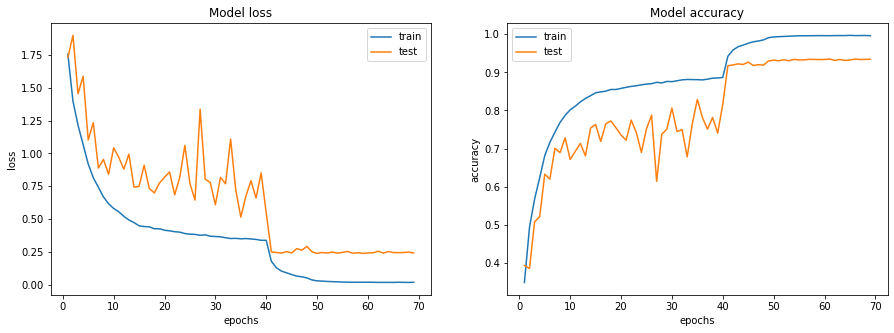

In [4]:
torch.cuda.empty_cache()
trainer = ModelTrainer(ds_train, ds_test, is_sparse=True, batch_size=100)

model = SparseWideResNet(depth=28, widen_factor=10, k_winners=0.1, local=False, boost=0.0, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-5, patience=4, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=80, patience=10)
plot_history(history)
torch.save(model.state_dict(), "../saved/sparse_wide_resnet_sgd_no_boost.pt")

cuda
Epoch: 1 Validation Loss: 1.5184 accuracy: 0.4620, time: 0:03:41                
Epoch: 2 Validation Loss: 1.8820 accuracy: 0.4461, time: 0:03:41                
epochs_no_improve: 1/10
Epoch: 3 Validation Loss: 1.4604 accuracy: 0.5151, time: 0:03:42                
Epoch: 4 Validation Loss: 1.1760 accuracy: 0.6072, time: 0:03:41                
Epoch: 5 Validation Loss: 0.9889 accuracy: 0.6609, time: 0:03:42                
Epoch: 6 Validation Loss: 1.1344 accuracy: 0.6452, time: 0:03:42                
epochs_no_improve: 1/10
Epoch: 7 Validation Loss: 1.0046 accuracy: 0.6752, time: 0:03:41                
epochs_no_improve: 2/10
Epoch: 8 Validation Loss: 0.8894 accuracy: 0.7030, time: 0:03:41                
Epoch: 9 Validation Loss: 1.2312 accuracy: 0.6314, time: 0:03:42                
epochs_no_improve: 1/10
Epoch: 10 Validation Loss: 1.0315 accuracy: 0.6802, time: 0:03:41               
epochs_no_improve: 2/10
Epoch: 11 Validation Loss: 0.9086 accuracy: 0.7001, time: 0:03:42

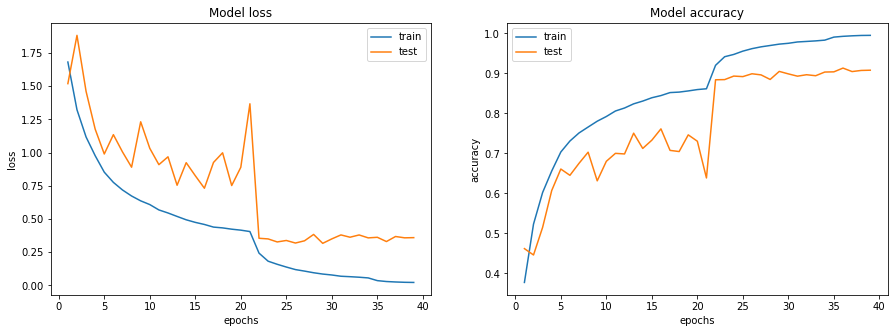

In [5]:
torch.cuda.empty_cache()
trainer = ModelTrainer(ds_train, ds_test, is_sparse=False, batch_size=100)

model = SparseWideResNet(depth=28, widen_factor=10, k_winners=0.1, local=False, boost=0.0, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-5, patience=4, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=80, patience=10)
plot_history(history)
torch.save(model.state_dict(), "../saved/sparse_wide_resnet_sgd_no_boost_rezero.pt")